In [18]:
import sys

sys.path.append('..')

In [19]:
from midasfpga.utils.dpu_utils import X_app
from midasfpga.dataset.nyuv2 import NyuDepthV2
from midasfpga.utils.metric import BadPixelMetric
from midasfpga.utils.func_utils import get_midas_transform, get_model
from midasfpga.configs.midas_config import Midas_Config
import torch
import torch.utils.data as data
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
conf = Midas_Config()
conf.MODEL_WEIGHTS = '../weights/midas_v21_small_256.pt'

model, device = get_model(conf)

CPU_ENFORCE = False
if CPU_ENFORCE:
    device = torch.device('cpu')

model = model.to(device)
transform = get_midas_transform()

Testing on cpu device.
Loading weights:  None


Using cache found in /home/ubuntu/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


In [21]:
xmodel_path = conf.FPGA_XMODEL_PATH 
data_dir=conf.FPGA_DATA_DIR
transform = get_midas_transform()

loss_delta_1 = []
loss_delta_2 = []
loss_delta_3 = []

total_time = 0

for partition_index in range(conf.FPGA_INDEX_LENGTH):
    ds = NyuDepthV2(data_dir, transform=transform, partition_index=partition_index)
    dl = data.DataLoader(
        ds, batch_size=1, num_workers=1, shuffle=False, pin_memory=True
    )
    metric = BadPixelMetric()
    loss_bsum1 = 0
    loss_bsum2 = 0
    loss_bsum3 = 0
    img = []

    print(f"Partition {partition_index}: Gathering images...")
    for i, batch in tqdm(enumerate(dl), total=conf.FPGA_PARTITION_LENGTH):
        img.append(batch['image'].permute(0, 2, 3, 1))

    print(f"Partition {partition_index}: Inferring depths on DPU...")
    duration, out_q = X_app(xmodel_path, img)

    total_time += duration

    print(f"Partition {partition_index}: Inference is completed\nEvaluating results...")
    for i, batch in tqdm(enumerate(dl), total=len(ds)):
        # run model
        prediction = out_q[i]

        # resize prediction to match target
        prediction = F.interpolate(
            torch.tensor(prediction).unsqueeze(0).unsqueeze(1),
            size=batch["mask"].shape[1:],
            mode="bilinear",
            align_corners=False,
        )
        prediction = prediction.squeeze(1)

        loss1, loss2, loss3, pd, t, e = metric(prediction, batch["depth"].to(torch.float32), batch["mask"])
        loss_bsum1 += loss1
        loss_bsum2 += loss2
        loss_bsum3 += loss3

    loss_delta_1.append(loss_bsum1 / len(ds))
    loss_delta_2.append(loss_bsum2 / len(ds))
    loss_delta_3.append(loss_bsum3 / len(ds))
    print(f"Partition {partition_index}: Bad pixel percentages for delta_1-3:")
    print(f"bad pixel1: {loss_bsum1 / len(ds):.2f}")
    print(f"bad pixel2: {loss_bsum2 / len(ds):.2f}")
    print(f"bad pixel3: {loss_bsum3 / len(ds):.2f}")
    print('-----------------------------------------------\n')

print("Average bad pixel: ", sum(loss_delta_1) / len(loss_delta_1))
print("Average bad pixel: ", sum(loss_delta_2) / len(loss_delta_2))
print("Average bad pixel: ", sum(loss_delta_3) / len(loss_delta_3))
print("Average fps: ", conf.FPGA_INDEX_LENGTH * len(dl.dataset) / total_time)



Partition 0: Gathering images...


100%|██████████| 109/109 [00:10<00:00, 10.35it/s]


Partition 0: Inferring depths on DPU...
---------------------------------------------------------------------------------------
Throughput=50.14 fps, total frames = 109, time=2.1740 seconds
Partition 0: Inference is completed
Evaluating results...


100%|██████████| 109/109 [00:26<00:00,  4.08it/s]


Partition 0: Bad pixel percentages for delta_1-3:
bad pixel1: 17.03
bad pixel2: 3.21
bad pixel3: 0.83
-----------------------------------------------

Partition 1: Gathering images...


 61%|██████    | 66/109 [00:09<00:05,  7.20it/s]


KeyboardInterrupt: 

[]

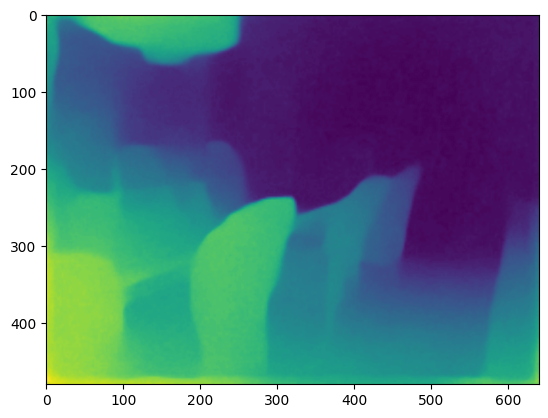

In [32]:
plt.imshow(prediction.squeeze()) #Plotting last prediction

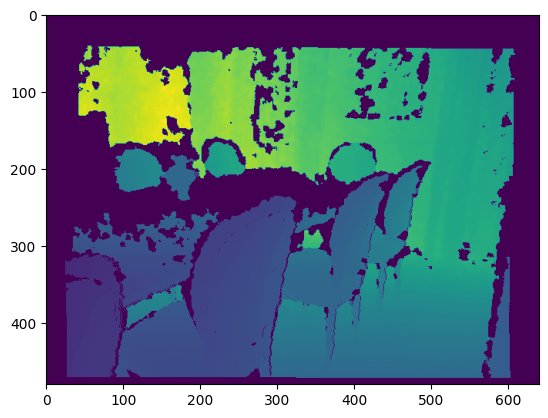

In [20]:
plt.imshow(batch['depth'].squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


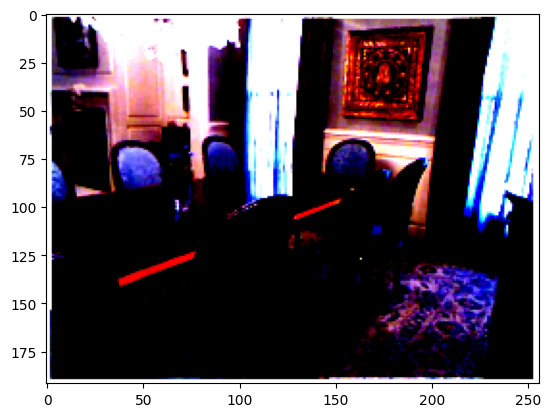

In [36]:
plt.imshow(batch['image'].squeeze().permute((1,2,0)))